# Titanic EDA — Feature Signals & Leakage Checks

Deeper analysis of engineered features and potential leakage risks.
- Extracts `Title` from `Name`, `Deck` from `Cabin`, and `TicketGroupSize`.
- Evaluates their association with `Survived`.
- Surfaces preprocessing ideas and pitfalls.

In [4]:
from __future__ import annotations
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set_theme(style="whitegrid")
except Exception:
    sns = None

DATA_TRAIN = '../data/train.csv'
DATA_TEST = '../data/test.csv'
train = pd.read_csv(DATA_TRAIN)
test = pd.read_csv(DATA_TEST)
target_col = 'Survived'
len(train), train.columns.tolist()

(891,
 ['PassengerId',
  'Survived',
  'Pclass',
  'Name',
  'Sex',
  'Age',
  'SibSp',
  'Parch',
  'Ticket',
  'Fare',
  'Cabin',
  'Embarked'])

## Feature Engineering

In [5]:
df = train.copy()

# Family size features
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# Title extraction from Name (e.g., 'Mr', 'Mrs', 'Miss', etc.)
def extract_title(name: str) -> str:
    m = re.search(r',\s*([^\.]+)\.', str(name))
    return m.group(1).strip() if m else 'Unknown'

df['Title'] = df['Name'].map(extract_title)
title_map = {
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Lady': 'Royal', 'Countess': 'Royal', 'Dona': 'Royal', 'Sir': 'Royal', 'Don': 'Royal',
    'Jonkheer': 'Rare', 'Capt': 'Rare', 'Col': 'Rare', 'Dr': 'Rare', 'Major': 'Rare', 'Rev': 'Rare'
}
df['Title'] = df['Title'].replace(title_map)

# Deck from Cabin (first letter); many missing
df['Deck'] = df['Cabin'].astype(str).str[0]
df['Deck'] = df['Deck'].where(df['Deck'].isin(list('ABCDEFGT')), other='U')

# Ticket group size: passengers sharing same ticket number (may indicate family/group)
ticket_counts = df['Ticket'].value_counts()
df['TicketGroupSize'] = df['Ticket'].map(ticket_counts)

df[['Survived', 'FamilySize', 'IsAlone', 'Title', 'Deck', 'TicketGroupSize']].head()

,Survived,FamilySize,IsAlone,Title,Deck,TicketGroupSize
0,0,2,0,Mr,U,1
1,1,2,0,Mrs,C,1
2,1,1,1,Miss,U,1
3,1,2,0,Mrs,C,2
4,0,1,1,Mr,U,1


## Survival Association

In [6]:
def survival_rate(df: pd.DataFrame, by: str) -> pd.DataFrame:
    return (df.groupby(by)['Survived']
              .agg(['mean', 'count'])
              .rename(columns={'mean': 'survival_rate'})
              .sort_values('survival_rate', ascending=False))

s_title = survival_rate(df, 'Title')
s_deck = survival_rate(df, 'Deck')
s_famsize = survival_rate(df, 'FamilySize')
s_isalone = survival_rate(df, 'IsAlone')
s_tgroup = survival_rate(df, 'TicketGroupSize')
s_title.head(), s_deck, s_famsize.head(), s_isalone, s_tgroup.head()

(              survival_rate  count
 Title                             
 the Countess       1.000000      1
 Mrs                0.793651    126
 Miss               0.702703    185
 Royal              0.666667      3
 Master             0.575000     40,
       survival_rate  count
 Deck                      
 D          0.757576     33
 E          0.750000     32
 B          0.744681     47
 F          0.615385     13
 C          0.593220     59
 G          0.500000      4
 A          0.466667     15
 U          0.299854    687
 T          0.000000      1,
             survival_rate  count
 FamilySize                      
 4                0.724138     29
 3                0.578431    102
 2                0.552795    161
 7                0.333333     12
 1                0.303538    537,
          survival_rate  count
 IsAlone                      
 0             0.505650    354
 1             0.303538    537,
                  survival_rate  count
 TicketGroupSize                   

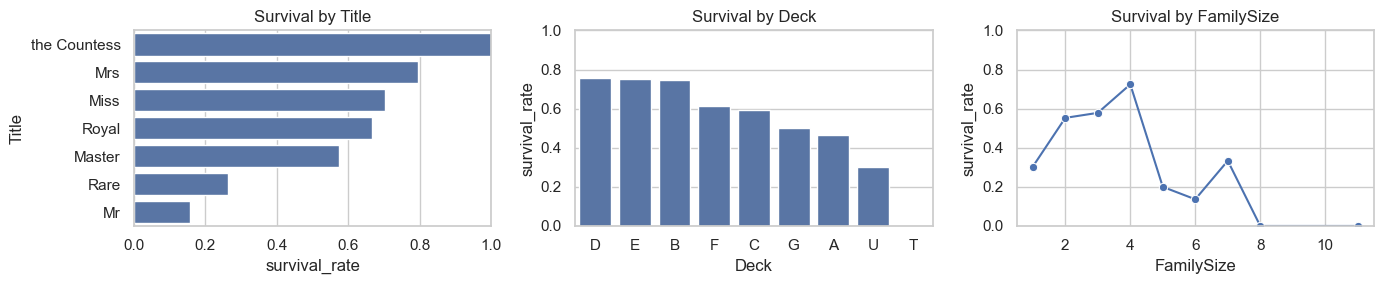

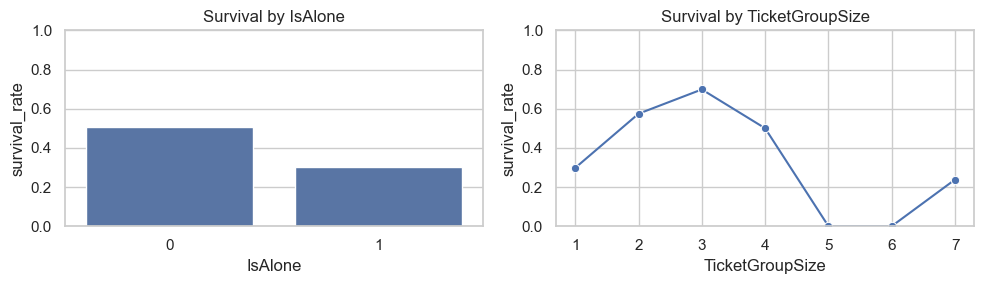

In [7]:
if sns is not None:
    fig, axes = plt.subplots(1, 3, figsize=(14, 3))
    sns.barplot(y=s_title.index, x=s_title['survival_rate'], ax=axes[0])
    axes[0].set_title('Survival by Title')
    axes[0].set_xlim(0, 1)
    sns.barplot(x=s_deck.index, y=s_deck['survival_rate'], ax=axes[1])
    axes[1].set_title('Survival by Deck')
    axes[1].set_ylim(0, 1)
    sns.lineplot(x=s_famsize.index, y=s_famsize['survival_rate'], marker='o', ax=axes[2])
    axes[2].set_title('Survival by FamilySize')
    axes[2].set_ylim(0, 1)
    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    sns.barplot(x=s_isalone.index.astype(str), y=s_isalone['survival_rate'], ax=axes[0])
    axes[0].set_title('Survival by IsAlone')
    axes[0].set_ylim(0, 1)
    sns.lineplot(x=s_tgroup.index, y=s_tgroup['survival_rate'], marker='o', ax=axes[1])
    axes[1].set_title('Survival by TicketGroupSize')
    axes[1].set_ylim(0, 1)
    plt.tight_layout()
    plt.show()


## Interactions

In [8]:
# Pclass x Sex survival heatmap
pt = pd.pivot_table(df, values='Survived', index='Pclass', columns='Sex', aggfunc='mean')
pt

Sex,female,male
Pclass,,
1,0.968085,0.368852
2,0.921053,0.157407
3,0.500000,0.135447


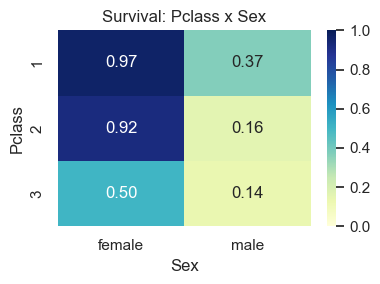

In [9]:
if sns is not None:
    plt.figure(figsize=(4, 3))
    sns.heatmap(pt, annot=True, fmt='.2f', cmap='YlGnBu', vmin=0, vmax=1)
    plt.title('Survival: Pclass x Sex')
    plt.tight_layout()
    plt.show()


## Leakage Checks
- `Cabin` might encode outcomes indirectly via deck/assignment; many missing, so low risk of overt leakage but strong proxy for class.
- `TicketGroupSize` reflects group travel, not post-outcome info — safe.
- `Fare` can be skewed; winsorizing/log-transform may help models.
- Avoid using target-encoded statistics computed on full data; if used, compute inside CV folds only.
- Compute all imputations/encodings within CV folds to prevent leakage.